In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.inspection import permutation_importance
from notebook_helper import MyCorpus, build_hybrid_model, build_callbacks, build_embedding_matrix, iteration_features
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

from string import ascii_letters
import time
import os

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

# Import necessary modules
from sklearn.model_selection import train_test_split, StratifiedKFold, StratifiedShuffleSplit

# Keras specific

#### CHANGED from import keras:
import tensorflow.keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential
#####
from keras.layers import Dense, LSTM, Embedding, Flatten, CuDNNLSTM, Bidirectional, Dropout


# from keras.utils import to_categorical

# Gemsim
import gensim.models
from gensim import utils

from numpy import array
from numpy import asarray
from numpy import zeros


from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay, balanced_accuracy_score

# from tensorflow.keras.layers import Embedding, Dense, LSTM
from tensorflow.keras.losses import BinaryCrossentropy
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
run_random_forests = True
cap_at_one = False

In [3]:
try:
    print("Before:\n" ,tf.config.get_visible_devices('GPU'))
    gpus = tf.config.list_physical_devices('GPU')
    tf.config.experimental.set_visible_devices(gpus[1], 'GPU')
    print("After:\n" ,tf.config.get_visible_devices('GPU'))
except IndexError as e:
    pass

Before:
 []


In [4]:
# Read the data
min_val = 50
repo_name = f"174repos_min{min_val}_max1000000"
# repo_name = f"300repos_min{min_val}_max1000000"
# repo_name = f"combination"
# df = pd.read_csv('../features/'+ repo_name +'_new_keyword_expanded.csv')
# df = pd.read_csv('../features/'+ repo_name +'_counts_expanded.csv')
df = pd.read_csv('../features/'+ repo_name +'_node_len_expanded.csv')
# df = pd.read_csv('../features/web2py.csv')

# Remove errors
df = df[df.parent != 'b']
df = df[df.type != 'b']

no_log_cnt, log_cnt = df['contains_logging'].value_counts()
par_vec_cnt = no_log_cnt + log_cnt
log_ratio = log_cnt / par_vec_cnt
print(f"Number of parameter vecs:\t\t{par_vec_cnt}")
print(f"without logging (negatives):\t{no_log_cnt}")
print(f"with logging (positives):\t\t{log_cnt}")
print(f"Log ratio:\t\t\t\t\t\t{log_ratio * 100:.2f}%")
print(df.shape)
df.head()

Number of parameter vecs:		18293
without logging (negatives):	17987
with logging (positives):		306
Log ratio:						1.67%
(18293, 32)


,type,location,length,parent,context,contains_class_definition,contains_function_definition,contains_if_statement,contains_for_statement,contains_match_statement,...,contains_exec_statement,contains_future_import_statement,contains_global_statement,contains_nonlocal_statement,contains_print_statement,contains_assignment,contains_call,contains_await,contains_yield,contains_logging
0,c,105;0-128;23,24,a,cqqdBdBdqirrrrmqrerrr,0,3,0,0,0,...,0,0,0,0,0,2,0,0,0,0
1,c,133;4-138;29,6,d,cderrrr,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,d,14;0-16;50,3,a,durr,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,d,18;0-60;18,43,a,deqrrerueruferuerqrrqrqrqrfrerukruu,0,0,4,2,0,...,0,0,0,0,0,3,3,0,0,0
4,d,63;0-67;51,5,a,drr,0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0


In [ ]:
if cap_at_one:
    for col in df.columns:
        if col.startswith("contains"):
            df[col] = df[col].apply(lambda x: min(1, x))

In [5]:
# Convert the compacted context from letters into strings of integers
df.context = [list(map(lambda y: str(ascii_letters.index(y)), list(str(x)))) for x in df.context]
df.head()

,type,location,length,parent,context,contains_class_definition,contains_function_definition,contains_if_statement,contains_for_statement,contains_match_statement,...,contains_exec_statement,contains_future_import_statement,contains_global_statement,contains_nonlocal_statement,contains_print_statement,contains_assignment,contains_call,contains_await,contains_yield,contains_logging
0,c,105;0-128;23,24,a,"[2, 16, 16, 3, 27, 3, 27, 3, 16, 8, 17, 17, 17...",0,3,0,0,0,...,0,0,0,0,0,2,0,0,0,0
1,c,133;4-138;29,6,d,"[2, 3, 4, 17, 17, 17, 17]",0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,d,14;0-16;50,3,a,"[3, 20, 17, 17]",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,d,18;0-60;18,43,a,"[3, 4, 16, 17, 17, 4, 17, 20, 4, 17, 20, 5, 4,...",0,0,4,2,0,...,0,0,0,0,0,3,3,0,0,0
4,d,63;0-67;51,5,a,"[3, 17, 17]",0,0,0,0,0,...,0,0,0,0,0,0,2,0,0,0


In [6]:
# Define X and y
X = df.drop(["location", "contains_logging"], axis=1)
# X = df.drop(["contains_logging"], axis=1)
X = pd.get_dummies(X, columns=["type", "parent"])
y = df.contains_logging
# Keep holdout set for testing after k-fold cross validation
X, X_holdout, y, y_holdout = train_test_split(X, y, test_size = 0.1, stratify=y, random_state=0)

In [7]:
# Word2Vec Model

sentences = MyCorpus(list(df.context))
gensim_model = gensim.models.Word2Vec(sentences=sentences, min_count=1)
actual_vocab_size = len(gensim_model.wv.key_to_index)
actual_vocab_size

28

In [ ]:
# Build an embedding for each context as the mean of its words' Word2Vec vectors
# corpus_embeddings = []
# for doc in sentences:
#     doc_embedding = np.zeros((len(doc), 100), dtype=np.float32)
#     for idx, word in enumerate(doc):
#                     doc_embedding[idx] = gensim_model.wv[word]
#     doc_embedding = np.mean(doc_embedding, axis=0)
#     corpus_embeddings.append(doc_embedding)
# corpus_embeddings = np.array(corpus_embeddings)
# df_corpus_embeddings = pd.DataFrame(corpus_embeddings, columns=["c"+str(i) for i in range(100)])
# df_corpus_embeddings.head()

In [ ]:
# TF-IDF
# vectorizer = TfidfVectorizer(token_pattern="\w+")
# concat_context = [" ".join(x) for x in df.context]
# vectorize_res = vectorizer.fit_transform(concat_context)
# df_tfidf = pd.DataFrame(vectorize_res.toarray(), columns=vectorizer.get_feature_names_out())
# df_tfidf.head()

In [8]:
score_names = [
    "Balanced accuracy score",
    "Precision score",
    "Recall score",
    "F1 Binary"
]

In [38]:
use_sampling = False
rnd_repo_name = repo_name + ("_counts" if not cap_at_one else "") + "_node_len" + ("_over" if use_sampling else "")
rnd_repo_name

'174repos_min50_max1000000_node_len'

Weight: 4
Starting fold 1.
Starting fold 2.
Starting fold 3.
Starting fold 4.
Starting fold 5.
Balanced accuracy score    0.693
Precision score            0.543
Recall score               0.391
F1 Binary                  0.454
dtype: float64


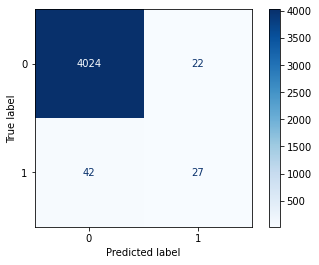

In [30]:
# Folded Random Forest Run
if run_random_forests:
    X_rnd = X.drop(["context"], axis=1)
    rnd_forest_sampling_strategy = 0.05
    use_sampling = False
    rnd_repo_name = repo_name + ("_counts" if not cap_at_one else "") + "_node_len" + ("_over" if use_sampling else "")
    n_splits=5
    # Hyper Params
    n_estimators = 9
    min_samples_split = 5
    min_samples_leaf = 1
    max_depth = None
    class_weight = {False: 1, True: 4}

    # List of the k classifiers from the k-fold split
    # classifiers = []

    df_regular = df.drop(["context"], axis=1)
    dataframes = [
        ("regular", df_regular),
        # ("corpus", df_corpus_embeddings.join(pd.DataFrame(df.contains_logging))),
        # ("tf-idf", df_tfidf.join(pd.DataFrame(df.contains_logging))),
        # ("regular+corpus", df_regular.join(df_corpus_embeddings)),
        # ("regular+tfidf", df_regular.join(df_tfidf)),
        # ("corpus+tfidf", df_corpus_embeddings.join(df_tfidf).join(pd.DataFrame(df.contains_logging))),
        # ("regular+corpus+tfidf", df_regular.join(df_corpus_embeddings).join(df_tfidf)),
    ]

    true_weight = 4
    # for df_name, df_used in dataframes:
    #     print(df_name)
    # for true_weight in [2,3,3.5,4,4.5,5]:
    for true_weight in [4]:
    # for n_estimators in [31,50,100]:
        class_weight = {False: 1, True: true_weight}
        print(f"Weight: {class_weight[True]} Estimators: {n_estimators}")
        all_scores = []
        conf_matrices = []
        # Split data into train and test sets
        # X = df_used.drop(["contains_logging", "location"], axis=1)
        # if "regular" in df_name:
        #     X = pd.get_dummies(X, columns=["type", "parent"])
        # y = df_used.contains_logging

        # classifier = RandomForestClassifier(n_estimators=200, random_state=0)
        # classifier = RandomForestClassifier(n_estimators=9, random_state=0)
        # skf = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
        skf = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.25)
        for k_fold, (train_index, test_index) in enumerate(skf.split(X_rnd, y)):
            print(f"Starting fold {k_fold + 1}.")
            classifier = RandomForestClassifier(n_estimators=n_estimators, n_jobs=-1,
                                           min_samples_split=min_samples_split,
                                           min_samples_leaf=min_samples_leaf,
                                           max_depth=max_depth,
                                           class_weight=class_weight)
            X_train, X_test = X_rnd.iloc[train_index], X_rnd.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            # Sampling
            if use_sampling:
                # sampler = RandomUnderSampler(sampling_strategy=rnd_forest_sampling_strategy)
                sampler = RandomOverSampler(sampling_strategy=rnd_forest_sampling_strategy)
                X_train, y_train = sampler.fit_resample(X_train, y_train)

            classifier.fit(X_train, y_train)
            classifiers.append(classifier)
            y_pred = classifier.predict(X_test)
            scores = [
                    balanced_accuracy_score(y_test, y_pred),
                    precision_score(y_test, y_pred),
                    recall_score(y_test, y_pred),
                    f1_score(y_test, y_pred, average='binary', pos_label=True)
            ]
            all_scores.append(scores)
            cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)
            conf_matrices.append(cm)
        score_df = pd.DataFrame(all_scores, columns=score_names).mean().round(3)

        # Testing with the holdout set, slightly different results but ultimately useless
        # X_rnd_holdout = X_holdout.drop(["context"], axis=1)
        # holdout_scores = []
        # for clf in classifiers:
        #     y_pred_holdout = clf.predict(X_rnd_holdout)
        #     scores = [
        #         balanced_accuracy_score(y_holdout, y_pred_holdout),
        #         precision_score(y_holdout, y_pred_holdout),
        #         recall_score(y_holdout, y_pred_holdout),
        #         f1_score(y_holdout, y_pred_holdout, average='binary', pos_label=True)
        #     ]
        #     holdout_scores.append(scores)

        print(score_df)
        avg_cm = np.mean(conf_matrices, axis=0).astype(int)
        disp = ConfusionMatrixDisplay(confusion_matrix=avg_cm,
                                      display_labels=classifier.classes_)
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
        out = open("my_approach_rnd_forest_results", "a")
        # out.write("Name, Timestamp, use_sampling, sampling_strategy, n_estimators, min_samples_split, class_weight, " + ", ".join(score_names) + "\n")
        out.write(f"{rnd_repo_name} {time.ctime()}, {use_sampling}, {rnd_forest_sampling_strategy}, {n_estimators}, {min_samples_split}, {class_weight}, " +
                  ", ".join([str(x) for x in score_df.values]) + "\n")
        out.close()

In [ ]:
# Random Forest: Feature importance based on mean decrease in impurity
if run_random_forests:
    sort_importances = True

    importances = classifier.feature_importances_
    std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)
    if sort_importances:
        importances,std,columns = list(zip(*sorted(list(zip(importances, std, X.columns)), reverse=True)))
    else:
        columns = X.columns

    forest_importances = pd.Series(importances, index=columns)

    fig, ax = plt.subplots()
    forest_importances.plot.bar(yerr=std, ax=ax)
    ax.set_title("Feature importances using MDI")
    ax.set_ylabel("Mean decrease in impurity")
    fig.set_size_inches(18.5, 18.5)

In [ ]:
# Random Forest: Feature importance based on feature permutation
if run_random_forests and False:
    # result = permutation_importance(classifier, X_rnd, y, n_repeats=10, random_state=0, n_jobs=-1)
    result = permutation_importance(classifier, X_holdout.drop(["context"], axis=1), y_holdout, n_repeats=10, n_jobs=-1)
    forest_permutation_importances = pd.Series(result.importances_mean, index=X_rnd.columns)

    fig, ax = plt.subplots()
    forest_permutation_importances.plot.bar(yerr=result.importances_std, ax=ax)
    ax.set_title("Feature importances using permutation on full model")
    ax.set_ylabel("Mean accuracy decrease")
    fig.tight_layout()
    fig.set_size_inches(18.5, 18.5)
    plt.show()

In [ ]:
# Data split for Tensorflow
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, stratify=y, random_state=0)
# X_train

In [ ]:
# print("Negatives: " + str(y_train[y_train == 0].shape[0]))
# print("Positives: " + str(y_train[y_train == 1].shape[0]))
# print("Ratio:\t   " + f"{y_train[y_train == 1].shape[0] / y_train[y_train == 0].shape[0] * 100:.2f}" + "%")

In [ ]:
# Smote doesn't seem to work with the context column
# over = SMOTE(random_state=0, sampling_strategy=0.1)
# X_train_resampled, y_train_resampled = over.fit_resample(X_train, y_train)

# over = RandomOverSampler(random_state=0, sampling_strategy=0.1)
# X_train_resampled, y_train_resampled = over.fit_resample(X_train, y_train)

# sampling_strategy = 0.05
# Choose one:
# sampler = RandomUnderSampler(random_state=0, sampling_strategy=sampling_strategy)
# sampler = RandomOverSampler(random_state=0, sampling_strategy=sampling_strategy)

# X_train_resampled, y_train_resampled = sampler.fit_resample(X_train, y_train)

In [ ]:
# print("Negatives: " + str(y_train_resampled[y_train_resampled == 0].shape[0]))
# print("Positives: " + str(y_train_resampled[y_train_resampled == 1].shape[0]))
# print("Ratio:\t   " + f"{y_train_resampled[y_train_resampled == 1].shape[0] / y_train_resampled[y_train_resampled == 0].shape[0] * 100:.2f}" + "%")

In [ ]:
# X_train, y_train = X_train_resampled, y_train_resampled

In [ ]:
# sampling_strategy = 0.05
sampling_strategy = 0.05
vocab_size = actual_vocab_size + 1
output_dims = 100
max_length = 80
num_epochs = 20
batch_size = 64
trainable=True
dropout = 0.2
val_split = 0.0
num_nodes = 128
callback = ["cp"]
callback_monitor = 'val_f1_score'
class_weight = "class_weight_unsupported"
cmpltn_metrics = [tfa.metrics.F1Score(num_classes=1, threshold=0.5)]

# Cross-validation settings
n_splits = 3

settings_hash = abs(hash(str([n_splits, sampling_strategy, vocab_size, output_dims, max_length, num_epochs, batch_size, trainable, dropout, val_split, num_nodes, callback, callback_monitor, class_weight, cmpltn_metrics]))) # TODO: DEPRECATE

In [ ]:
# Build embedding matrix
embedding_matrix = build_embedding_matrix(vocab_size, output_dims, gensim_model)

In [ ]:
# DEPRECATED: Not usable with k-fold cross-validation
# Pad the context
# padded_context = pad_sequences(np.array(X.context), maxlen=max_length, value=0.0)
# Prepare the "other" input
# other_input = X.drop(["context"], axis=1)

In [ ]:
# DEPRECATED
# Pad the context to create the context input
# padded_inputs = pad_sequences(np.array(list(X_train.context), dtype=object), maxlen=max_length, value=0.0)  # 0.0 because it corresponds with <PAD>
# padded_inputs_test = pad_sequences(np.array(list(X_test.context), dtype=object), maxlen=max_length, value=0.0)  # 0.0 because it corresponds with <PAD>
# padded_inputs

In [ ]:
# DEPRECATED
# Prepare the "other" input
# regular_inputs = X_train.drop(["context", "location"], axis=1)
# regular_inputs_test = X_test.drop(["context", "location"], axis=1)
# regular_inputs = X_train.drop(["context"], axis=1)
# regular_inputs_test = X_test.drop(["context"], axis=1)
# regular_inputs.shape

In [ ]:
# Prepare holdout test sets
padded_inputs_holdout = pad_sequences(np.array(list(X_holdout.context), dtype=object), maxlen=max_length, value=0.0)
regular_inputs_holdout = X_holdout.drop(["context"], axis=1)
X_holdout_dict = {"context": padded_inputs_holdout, "other": regular_inputs_holdout}

In [ ]:
run_name = f"{repo_name[:3]}_min{min_val}_hybrid" + ("_counts" if not cap_at_one else "") + f"_node_len_cv{n_splits}"
run_number = 1
# if not os.path.isdir(f"hybrid_models"):
if not os.getcwd().endswith("notebooks"):
    raise Exception("Bad working directory")
while os.path.isdir(f"hybrid_models/{repo_name}/run{run_number}/"):
    run_number += 1
run_folder = f"run{run_number}"

# DEBUG
debug = False
if debug:
    num_epochs = 1
    batch_size = 256
    n_splits = 1
    settings_hash = abs(hash(str(time.ctime())))
    run_folder = settings_hash
    run_name = f"DEBUG_{run_name}"
# /DEBUG

start = time.time()
histories = []

# List of (X_test_dict, y_test) of all folds
test_sets = []

model = build_hybrid_model(vocab_size, output_dims, embedding_matrix, max_length,
                       trainable, num_nodes, dropout, X.shape[1] - 1)
# model.summary()

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=cmpltn_metrics)

final_bal_acc_all, final_precision_all, final_recall_all, final_f1_all = [], [], [], []
best_bal_acc_all, best_precision_all, best_recall_all, best_f1_all = [], [], [], []
# K-fold cross-validation
if n_splits == 1:
    indices = np.arange(y.shape[0])
    strat_train_idx, strat_val_idx = train_test_split(indices, test_size=0.25, stratify=y, random_state=0)
    idx_iter = [(strat_train_idx, strat_val_idx)]
else:
    skf = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.25, random_state=0)
    idx_iter = skf.split(X, y)
for k_fold, (train_index, test_index) in enumerate(idx_iter):
    print(f"Starting fold {k_fold + 1} of {n_splits}.")
    prog_log = open("progess.log", "a")
    prog_log.write(f"{time.ctime()} Starting fold {k_fold + 1} of {n_splits}. Run folder: {run_folder}\n")
    prog_log.close()
    # Split the data into train and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Oversample the minority class
    sampler = RandomOverSampler(sampling_strategy=sampling_strategy)
    X_train, y_train = sampler.fit_resample(X_train, y_train)
    # Pad the context to create the context input
    padded_inputs = pad_sequences(np.array(list(X_train.context), dtype=object), maxlen=max_length, value=0.0)
    padded_inputs_test = pad_sequences(np.array(list(X_test.context), dtype=object), maxlen=max_length, value=0.0)
    # Prepare the "other" input
    regular_inputs = X_train.drop(["context"], axis=1)
    regular_inputs_test = X_test.drop(["context"], axis=1)
    # Put both inputs into a dict
    X_train_dict = {"context": padded_inputs, "other": regular_inputs}
    X_test_dict = {"context": padded_inputs_test, "other": regular_inputs_test}
    # Append to the list of test sets
    test_sets.append((X_test_dict, y_test))
    # Build the callbacks
    callbacks, model_cp_filepath = build_callbacks(callback, callback_monitor, repo_name, run_folder, k_fold, zhenhao=False)
    # Fit the model
    history = model.fit(
        X_train_dict,
        {"logging": y_train},
        epochs=num_epochs,
        batch_size=batch_size,
        validation_data=(X_test_dict, y_test),
        validation_split=val_split,
        callbacks=callbacks,
    )
    histories.append(history)

    # Predict with final weights
    pred_test= model.predict(X_test_dict, batch_size=batch_size)
    y_pred = np.round(pred_test)
    final_bal_acc_all.append(balanced_accuracy_score(y_test, y_pred))
    final_precision_all.append(precision_score(y_test, y_pred))
    final_recall_all.append(recall_score(y_test, y_pred))
    final_f1_all.append(f1_score(y_test, y_pred))
    # Now load the best weights and predict on test data again
    if "cp" in callback:
            model.load_weights(model_cp_filepath)
            best_pred_test= model.predict(X_test_dict, batch_size=batch_size)
            best_y_pred = np.round(best_pred_test)
            best_bal_acc_all.append(balanced_accuracy_score(y_test, best_y_pred))
            best_precision_all.append(precision_score(y_test, best_y_pred))
            best_recall_all.append(recall_score(y_test, best_y_pred))
            best_f1_all.append(f1_score(y_test, best_y_pred))

# Determine best fold and predict on holdout set
best_fold = np.argmax(best_f1_all)
# best_fold_filepath = f'zhenhao_models/{repo_name}/{run_folder}/fold{best_fold}'
best_fold_filepath = f'hybrid_models/{repo_name}/{run_folder}/fold{best_fold}'
model.load_weights(best_fold_filepath)
pred_holdout= model.predict(X_holdout_dict, batch_size=batch_size)
y_pred_holdout = np.round(pred_holdout)

end = time.time()
execution_time = int(end - start)

scores = [
    run_name,
    time.ctime(),
    sampling_strategy,
    max_length,
    vocab_size,
    batch_size,
    trainable,
    dropout,
    val_split,
    callback,
    callback_monitor,
    num_nodes,
    num_epochs,
    class_weight,
    list(map(lambda x: x.name if callable(x) else x, cmpltn_metrics)),
    run_folder,
    execution_time,
    f"{np.mean(final_bal_acc_all, axis=0):.2f}"[2:],
    f"{np.mean(final_precision_all, axis=0):.2f}"[2:],
    f"{np.mean(final_recall_all, axis=0):.2f}"[2:],
    f"{np.mean(final_f1_all, axis=0):.3f}"[2:],
    f"{np.mean(best_bal_acc_all, axis=0):.2f}"[2:],
    f"{np.mean(best_precision_all, axis=0):.2f}"[2:],
    f"{np.mean(best_recall_all, axis=0):.2f}"[2:],
    f"{np.mean(best_f1_all, axis=0):.3f}"[2:],
    best_fold,
    f"{best_f1_all[best_fold]:.3f}"[2:],
    f"{balanced_accuracy_score(y_holdout, y_pred_holdout):.2f}"[2:],
    f"{precision_score(y_holdout, y_pred_holdout):.2f}"[2:],
    f"{recall_score(y_holdout, y_pred_holdout):.2f}"[2:],
    f"{f1_score(y_holdout, y_pred_holdout):.3f}"[2:],
]
out = open("results.txt", "a")
# out.write(iteration_features + ", Final_Bal_Acc, Final_Prec, Final_Recall, Final_F1, Best_Bal_Acc, Best_Prec, Best_Recall, Best_F1, Best_Fold, Best_Fold_F1, Best_Fold_Holdout_Bal_Acc, Best_Fold_Holdout_Prec, Best_Fold_Holdout_Recall, Best_Fold_Holdout_F1 \n")
out.write(str(scores).replace("'", "")[1:-1] + "\n")
out.close()

In [ ]:
# Load a model that did well
# checkpoint_filepath = 'zhenhao_models/174repos_min50_max1000000/4609183334028858880/fold2'
# model.load_weights(checkpoint_filepath)

In [ ]:
# Test on the last fold's test set (bad)
# pred_test= model.predict(X_test_dict, batch_size=batch_size)
# y_pred = np.round(pred_test)
# print(balanced_accuracy_score(y_test, y_pred))
# print(precision_score(y_test, y_pred))
# print(recall_score(y_test, y_pred))
# print(f1_score(y_test, y_pred))

In [ ]:
# Load the weights of the best fold
# checkpoint_filepath = f'zhenhao_models/{repo_name}/{settings_hash}/fold{best_fold}'
# checkpoint_filepath = f'hybrid_models/{repo_name}/{run_folder}/fold{best_fold}'
# Alternatively, Load the weights of a model that did well
# checkpoint_filepath = 'zhenhao_models/174repos_min50_max1000000/4609183334028858880/fold2'

# model.load_weights(checkpoint_filepath)
# Test on the holdout set (good)
# pred_holdout= model.predict(X_holdout_dict, batch_size=batch_size)
# y_pred_holdout = np.round(pred_holdout)
# print(balanced_accuracy_score(y_holdout, y_pred_holdout))
# print(precision_score(y_holdout, y_pred_holdout))
# print(recall_score(y_holdout, y_pred_holdout))
# print(f1_score(y_holdout, y_pred_holdout))

In [ ]:
# Legacy only "others" run
legacy = False
if legacy:
    run_name = f"{repo_name[:3]}_min{min_val}_onlyOthers_new_keyword_cv{n_splits}"
    settings_hash = abs(hash(str(time.ctime())))

    # DEBUG
    debug = False
    if debug:
        num_epochs = 1
        batch_size = 256
        n_splits = 1
        settings_hash = int((hash(str(time.ctime())) ** 2) ** 0.5)
        run_name = f"DEBUG_{run_name}"
    # /DEBUG

    start = time.time()
    histories = []


    # List of (X_test_dict, y_test) of all folds
    test_sets = []

    # N.y.i. on remote
    # model = build_others_model(vocab_size, output_dims, embedding_matrix, max_length,
    #                        trainable, num_nodes, dropout, X.shape[1] - 1)
    model = Sequential()
    model.add(keras.Input(shape=(X.shape[1] - 1,)))
    model.add(Dense(300, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # model.summary()

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=cmpltn_metrics)

    final_bal_acc_all, final_precision_all, final_recall_all, final_f1_all = [], [], [], []
    best_bal_acc_all, best_precision_all, best_recall_all, best_f1_all = [], [], [], []
    # K-fold cross-validation
    if n_splits == 1:
        indices = np.arange(y.shape[0])
        strat_train_idx, strat_val_idx = train_test_split(indices, test_size=0.25, stratify=y, random_state=0)
        idx_iter = [(strat_train_idx, strat_val_idx)]
    else:
        skf = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.25, random_state=0)
        idx_iter = skf.split(X, y)
    for k_fold, (train_index, test_index) in enumerate(idx_iter):
        print(f"Starting fold {k_fold + 1} of {n_splits}.")
        prog_log = open("progess.log", "a")
        prog_log.write(f"{time.ctime()} Starting fold {k_fold + 1} of {n_splits}. Settings hash: {settings_hash}\n")
        prog_log.close()
        # Split the data into train and test sets
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        # Oversample the minority class
        sampler = RandomOverSampler(sampling_strategy=sampling_strategy)
        X_train, y_train = sampler.fit_resample(X_train, y_train)
        # Pad the context to create the context input
        # padded_inputs = pad_sequences(np.array(list(X_train.context), dtype=object), maxlen=max_length, value=0.0)
        # padded_inputs_test = pad_sequences(np.array(list(X_test.context), dtype=object), maxlen=max_length, value=0.0)
        # Prepare the "other" input
        regular_inputs = X_train.drop(["context"], axis=1)
        regular_inputs_test = X_test.drop(["context"], axis=1)
        # Put both inputs into a dict
        # X_train_dict = {"context": padded_inputs, "other": regular_inputs}
        # X_test_dict = {"context": padded_inputs_test, "other": regular_inputs_test}
        # Append to the list of test sets
        # test_sets.append((X_test_dict, y_test))
        # Build the callbacks
        callbacks, model_cp_filepath = build_callbacks(callback, callback_monitor, repo_name, settings_hash, k_fold)
        # Fit the model
        history = model.fit(
            regular_inputs,
            y_train,
            epochs=num_epochs,
            batch_size=batch_size,
            validation_data=(regular_inputs_test, y_test),
            validation_split=val_split,
            callbacks=callbacks,
        )
        histories.append(history)

        # Predict with final weights
        pred_test= model.predict(regular_inputs_test, batch_size=batch_size)
        y_pred = np.round(pred_test)
        final_bal_acc_all.append(balanced_accuracy_score(y_test, y_pred))
        final_precision_all.append(precision_score(y_test, y_pred))
        final_recall_all.append(recall_score(y_test, y_pred))
        final_f1_all.append(f1_score(y_test, y_pred))
        # Now load the best weights and predict on test data again
        if "cp" in callback:
                model.load_weights(model_cp_filepath)
                best_pred_test= model.predict(regular_inputs_test, batch_size=batch_size)
                best_y_pred = np.round(best_pred_test)
                best_bal_acc_all.append(balanced_accuracy_score(y_test, best_y_pred))
                best_precision_all.append(precision_score(y_test, best_y_pred))
                best_recall_all.append(recall_score(y_test, best_y_pred))
                best_f1_all.append(f1_score(y_test, best_y_pred))

    # Determine best fold and predict on holdout set
    best_fold = np.argmax(best_f1_all)
    best_fold_filepath = f'zhenhao_models/{repo_name}/{settings_hash}/fold{best_fold}'
    model.load_weights(best_fold_filepath)
    pred_holdout= model.predict(regular_inputs_holdout, batch_size=batch_size)
    y_pred_holdout = np.round(pred_holdout)

    end = time.time()
    execution_time = int(end - start)

    scores = [
        run_name,
        time.ctime(),
        sampling_strategy,
        max_length,
        vocab_size,
        batch_size,
        trainable,
        dropout,
        val_split,
        callback,
        callback_monitor,
        num_nodes,
        num_epochs,
        class_weight,
        list(map(lambda x: x.name if callable(x) else x, cmpltn_metrics)),
        settings_hash,
        execution_time,
        f"{np.mean(final_bal_acc_all, axis=0):.2f}"[2:],
        f"{np.mean(final_precision_all, axis=0):.2f}"[2:],
        f"{np.mean(final_recall_all, axis=0):.2f}"[2:],
        f"{np.mean(final_f1_all, axis=0):.3f}"[2:],
        f"{np.mean(best_bal_acc_all, axis=0):.2f}"[2:],
        f"{np.mean(best_precision_all, axis=0):.2f}"[2:],
        f"{np.mean(best_recall_all, axis=0):.2f}"[2:],
        f"{np.mean(best_f1_all, axis=0):.3f}"[2:],
        best_fold,
        f"{best_f1_all[best_fold]:.3f}"[2:],
        f"{balanced_accuracy_score(y_holdout, y_pred_holdout):.2f}"[2:],
        f"{precision_score(y_holdout, y_pred_holdout):.2f}"[2:],
        f"{recall_score(y_holdout, y_pred_holdout):.2f}"[2:],
        f"{f1_score(y_holdout, y_pred_holdout):.3f}"[2:],
    ]
    out = open("results.txt", "a")
    # out.write(iteration_features + ", Final_Bal_Acc, Final_Prec, Final_Recall, Final_F1, Best_Bal_Acc, Best_Prec, Best_Recall, Best_F1, Best_Fold, Best_Fold_F1, Best_Fold_Holdout_Bal_Acc, Best_Fold_Holdout_Prec, Best_Fold_Holdout_Recall, Best_Fold_Holdout_F1 \n")
    out.write(str(scores).replace("'", "")[1:-1] + "\n")
    out.close()